In [1]:
import numpy as np 
from scipy.integrate import solve_ivp
from matplotlib import pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from itertools import product
from time import time

In [12]:
data = np.load('part1a.npz')
data.files

['N', 'Svc_0_pmf', 'Lc', 'Ic_0', 'gamma']

In [13]:
# Total population, N.
N = data['N']
# Everyone else, S0, is susceptible to infection initially.
S = data['Svc_0_pmf'] * data['N']
# Initial number of infected and recovered individuals, I0 and R0.
I = data['Ic_0']
R = 0
# Contact rate: beta, mean recovery rate: gamma (in 1/days).
gamma = data['gamma']
beta = np.linspace(0.1,0.3,16).reshape(4,4) # arbitrary non-decreasing beta values
L = data['Lc']

t = (0, 120)

In [ ]:
def SIR(t, y, L, N, beta, gamma):
    '''Must solve 4 Ic in order to solve 1 Svc. Must 
    solve 4 Svc in order to solve 1 Ic. Must solve 4 Ic in order to solve
    1 R. Must solve 4 Ic to solve 1  L.'''
    S00, S01, S02, S03,\
    S10,S11,S12,S13, \
    S20,S21,S22, S23, \
    S30,S31,S32,S33, \
    I1, I2, I3, I4, \
    I0, R0 = y

    dS00dt = -beta[0,0] * S00 * I0 / N
    dS10dt = -beta[1,0] * S10 * I0 / N
    dS20dt = -beta[2,0] * S20 * I0 / N
    dS30dt = -beta[3,0] * S30 * I0 / N
    
    dS01dt = -beta[0,1] * S01 * I0 / N
    dS11dt = -beta[1,1] * S11 * I0 / N
    dS21dt = -beta[2,1] * S21 * I0 / N
    dS31dt = -beta[3,1] * S31 * I0 / N
    
    dS02dt = -beta[0,2] * S02 * I0 / N
    dS12dt = -beta[1,2] * S12 * I0 / N
    dS22dt = -beta[2,2] * S22 * I0 / N
    dS32dt = -beta[3,2] * S32 * I0 / N

    dS03dt = -beta[0,3] * S03 * I0 / N
    dS13dt = -beta[1,3] * S13 * I0 / N
    dS23dt = -beta[2,3] * S23 * I0 / N
    dS33dt = -beta[3,3] * S33 * I0 / N
    
    dI1dt = -1 * np.sum([dS00dt,dS10dt,dS20dt,dS30dt]) - (gamma * I1)
    dI2dt = -1 * np.sum([dS01dt,dS11dt,dS21dt,dS31dt]) - (gamma * I2)
    dI3dt = -1 * np.sum([dS02dt,dS12dt,dS22dt,dS32dt]) - (gamma * I3)
    dI4dt = -1 * np.sum([dS03dt,dS13dt,dS23dt,dS33dt]) - (gamma * I4)
    dIdt = np.sum([dI1dt, dI2dt, dI3dt, dI4dt]) 
    
    dRdt = gamma * I0
    
#     print(f'dSdt = {dSdt}\n')
#     print(f'dIdt = {dIdt}\n')
#     print(f'dRdt = {dRdt}\n')
    
    return dS00dt, dS01dt, dS02dt, dS03dt,\
    dS10dt,dS11dt,dS12dt,dS13dt, \
    dS20dt,dS21dt,dS22dt, dS23dt, \
    dS30dt,dS31dt,dS32dt,dS33dt, \
    dI1dt, dI2dt, dI3dt, dI4dt, \
    dIdt, dRdt

In [ ]:
fig, ax = plt.subplots(1, 3, sharex = True, figsize = (30,15) )
# ax[0].set(xlabel = "t (Time in days)", ylabel = "Number",
#          title = "SIR Curve")
soln = solve_ivp(SIR, t, y0 = (S[0,0],S[0,1],S[0,2],S[0,3],
                               S[1,0],S[1,1],S[1,2],S[1,3],
                               S[2,0],S[2,1],S[2,2],S[2,3],
                               S[3,0],S[3,1],S[3,2],S[3,3],
                               I[0],I[1],I[2],I[3], I.sum(), R), 
                 dense_output = True, t_eval=np.arange(121),\
                 args = (L, N, beta, gamma) )
S00, S01, S02, S03,\
    S10,S11,S12,S13, \
    S20,S21,S22, S23, \
    S30,S31,S32,S33, \
    I1, I2, I3, I4, \
    I0, R0 = soln.y

all_S = [S00, S01, S02, S03,\
    S10,S11,S12,S13, \
    S20,S21,S22, S23, \
    S30,S31,S32,S33]
all_I = [I1,I2,I3,I4]
# Plot viral load density L
Lty = (I1 * L[0] + I2 * L[1] + I[3] * L[2] + I4 * L[3])
ax[2].plot(soln.t, Lty, 'black', alpha = 0.75, lw = 2, label = 'Viral Load Density')
# Plot Susceptible vc
for Svc in all_S:
    ax[0].plot(soln.t, Svc, 'b', alpha=0.5, lw=2, label='Susceptible')

# Plot # Infected vc
for Ic in all_I:
    ax[0].plot(soln.t, Ic, 'r', alpha=0.5, lw=2, label='Infected')

# Plot Overall S, I, R
ax[1].plot(soln.t, np.sum(all_S, axis = 0), 'b', alpha=0.5, lw=2, label='Susceptible')
ax[1].plot(soln.t, np.sum(all_I, axis = 0),'r', alpha=0.5, lw=2, label='Infected')
ax[1].plot(soln.t, R0, 'g', alpha=0.5, lw=2, label='Recovered with immunity')

# Proportion of susceptible people who never were infected

In [203]:
for i, Svc in enumerate(all_S):
    #print(f"i: {i}, Svc[-1]: {Svc[-1]}, Svc[0]: {Svc[0]}\n")
    print(f"Proportion {i}: {Svc[-1]/Svc[0]}")

Proportion 0: 0.30385930986884385
Proportion 1: 0.25925183318555345
Proportion 2: 0.22116861930870635
Proportion 3: 0.18864642323700023
Proportion 4: 0.16086522528162292
Proportion 5: 0.13712696724770584
Proportion 6: 0.11683742143621478
Proportion 7: 0.09949073472600328
Proportion 8: 0.08465625641671017
Proportion 9: 0.07196731535123997
Proportion 10: 0.06111166046891348
Proportion 11: 0.05182332054652795
Proportion 12: 0.043875674474910344
Proportion 13: 0.037075553858456
Proportion 14: 0.03125822575595577
Proportion 15: 0.02628312563766615


# 6.

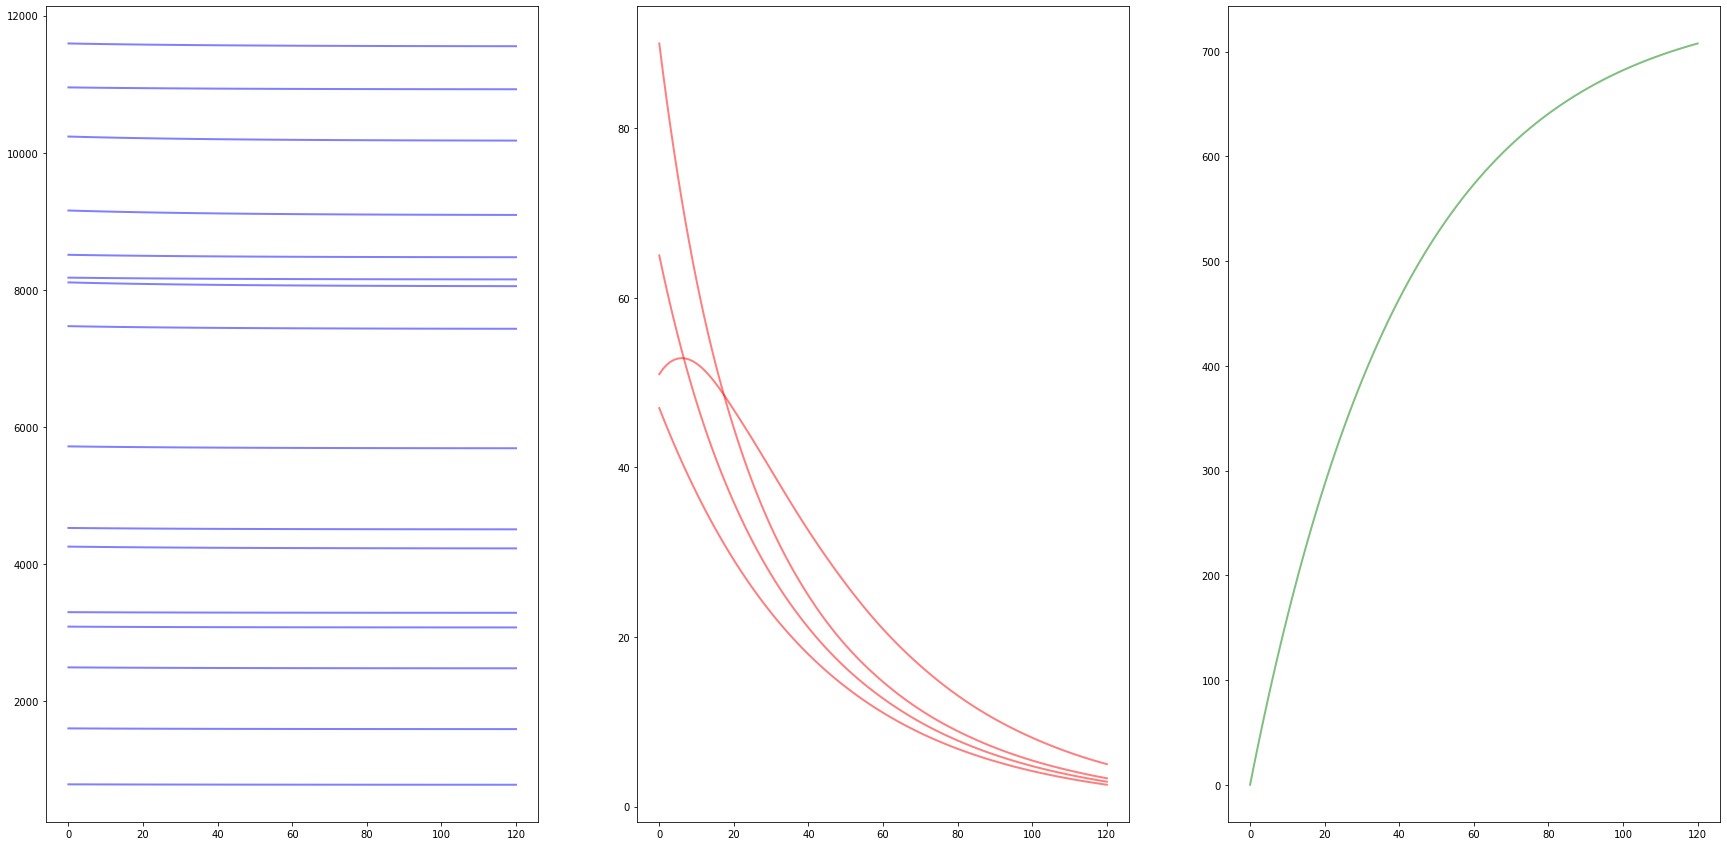

In [191]:
fig, ax = plt.subplots(1, 3, sharex = True, figsize = (30,15) )
# ax[0].set(xlabel = "t (Time in days)", ylabel = "Number",
#          title = "SIR Curve")
soln = solve_ivp(SIR, t, y0 = (S[0,0],S[0,1],S[0,2],S[0,3],
                               S[1,0],S[1,1],S[1,2],S[1,3],
                               S[2,0],S[2,1],S[2,2],S[2,3],
                               S[3,0],S[3,1],S[3,2],S[3,3],
                               I[0],I[1],I[2],I[3], I.sum(), R), 
                 dense_output = True, t_eval=np.arange(121),\
                 args = (L, N, beta/4, gamma) )
S00, S01, S02, S03,\
    S10,S11,S12,S13, \
    S20,S21,S22, S23, \
    S30,S31,S32,S33, \
    I1, I2, I3, I4, \
    I0, R0 = soln.y

all_S = [S00, S01, S02, S03,\
    S10,S11,S12,S13, \
    S20,S21,S22, S23, \
    S30,S31,S32,S33]
for Svc in all_S:
    ax[0].plot(soln.t, Svc, 'b', alpha=0.5, lw=2, label='Susceptible')

for Ic in [I1,I2,I3,I4]:
    ax[1].plot(soln.t, Ic, 'r', alpha=0.5, lw=2, label='Infected')

ax[2].plot(soln.t, R0, 'g', alpha=0.5, lw=2, label='Recovered with immunity')

## Part 1b

In [2]:
bdata = np.load("part1b.npz")

In [3]:
bdata.files

['N', 'Lc', 'Ic_0', 'gamma', 'L_validation', 'L_test', 'betas_validation']

In [4]:
N_b = bdata['N'] # Each node has population N
L_b = bdata['Lc']
I_b = bdata['Ic_0']
gamma_b = bdata['gamma']
L_validation = bdata['L_validation']
L_test = bdata['L_test']
betas_validation = bdata['betas_validation']

In [5]:
def SIR_b(t, y, N, beta, gamma):
    
    Sv0, Sv1, Sv2, Sv3, I0, I1, I2, I3, I = y

    dSv0dt = -beta[0] * Sv0 * I / N
    dSv1dt = -beta[1] * Sv1 * I / N
    dSv2dt = -beta[2] * Sv2 * I / N
    dSv3dt = -beta[3] * Sv3 * I / N
    
    dI0dt = -1 * dSv0dt - (gamma * I0)
    dI1dt = -1 * dSv1dt - (gamma * I1)
    dI2dt = -1 * dSv2dt - (gamma * I2)
    dI3dt = -1 * dSv3dt - (gamma * I3)
    
    dIdt = np.sum([dI0dt, dI1dt, dI2dt, dI3dt]) 
    
#     print(f'dSdt = {dSdt}\n')
#     print(f'dIdt = {dIdt}\n')
#     print(f'dRdt = {dRdt}\n')
    
    return dSv0dt, dSv1dt, dSv2dt, dSv3dt,\
    dI0dt, dI1dt, dI2dt, dI3dt, \
    dIdt

# 1.

In [20]:
# Beta Grid Search

def beta_gridsearch(beta_grid):
    '''Select what beta values you want to search for thru beta_grid
    e.g. beta_grid = np.linspace(0,1,21)'''
    pmf = [0.5,0.3,0.1,0.1,0.4,0.3,0.2,0.1,0.3,0.3,0.2,0.2,0.1,0.2,0.3,0.4]
    beta_mmse=np.zeros((4,4))
    prev_beta_vc = np.zeros(4)
    
    # Create initial values in vulnerability group v for grid search
    for start, end, pmf_start, pmf_end, i in \
    zip(range(0,20,5), range(5,25,5), range(0,16,4), range(4,20,4), range(4)):
        mmse = np.inf
        pmf0c = np.array(pmf[pmf_start:pmf_end])
        Sv0, Sv1, Sv2, Sv3 = pmf0c * 50000 * 5
        I0,I1,I2,I3 = I_b[start:end].sum(axis = 0)
        I_five_nodes = np.sum([I0,I1,I2,I3])

        start_time = time()
        # Grid search for optimal values of beta 
        for (betav0, betav1, betav2, betav3) in product(beta_grid, beta_grid, beta_grid, beta_grid):
            
            # Boolean
            bigger_than_prev_beta = (betav0 >= prev_beta_vc[0]) and betav1 >=(prev_beta_vc[1])\
            and (betav2 >= prev_beta_vc[2]) and (betav3 >=prev_beta_vc[3])
            
            # Check if beta values are greater as vulnerability increases and comorbidity increases, ignore
            # ignore product of beta values if conditions not satisfied
            if (betav0 <= betav1 <= betav2 <= betav3) and\
            bigger_than_prev_beta:
                # If beta values valid, solve ODE with 
                beta = [betav0, betav1, betav2, betav3]
                
                # Solve ODE
                soln_obj = solve_ivp(SIR_b, t_span = (0,19), \
                                     y0 = (Sv0, Sv1, Sv2, Sv3,
                                     I0,I1,I2,I3, I_five_nodes), \
                                     t_eval = np.arange(20), dense_output = True, \
                                     args = (N_b * 5, beta, gamma_b))
                # Assign solutions from solution object
                Sv0_y, Sv1_y, Sv2_y, Sv3_y, I0_y, I1_y, I2_y, I3_y, I_nodes = soln_obj.y
                # Calculate sample L and MSE
                L_sample = np.sum(np.array([I0_y * L_b[0], I1_y * L_b[1],I2_y * L_b[2],I3_y * L_b[3]]), axis = 0)
                mse = mean_squared_error(np.sum(L_validation[start:end], axis = 0), L_sample) 

                # If mse is lower, store new value
                if mse < mmse:
                    mmse = mse
                    beta_mmse[i,:] = beta
                    
        # Store beta mmse estimates of previous vulnerability group for checking           
        prev_beta_vc = beta_mmse[i,:]
        end_time = time()
        
        print(f"Run time: {end_time - start_time:.2f} seconds")
        print(f"Estimated values are beta={beta_mmse[i,:]}")
        print(f"MMSE = {mmse}\n")
    return beta_mmse

In [21]:
beta_grid=np.linspace(0,1,21)
beta_mmse = beta_gridsearch(beta_grid)

Run time: 30.06 seconds
Estimated values are beta=[0.1  0.15 0.2  0.25]
MMSE = 133.36327106918728

Run time: 23.64 seconds
Estimated values are beta=[0.15 0.25 0.35 0.45]
MMSE = 2496.594473936867

Run time: 20.68 seconds
Estimated values are beta=[0.5  0.5  0.55 0.6 ]
MMSE = 18439769.379344363

Run time: 4.95 seconds
Estimated values are beta=[0.55 0.55 0.55 0.75]
MMSE = 749086.4567411983



In [16]:
betas_validation

array([[0.1 , 0.15, 0.2 , 0.25],
       [0.2 , 0.25, 0.3 , 0.4 ],
       [0.35, 0.45, 0.5 , 0.6 ],
       [0.4 , 0.5 , 0.6 , 0.8 ]])

# Debugging

In [24]:
fig, ax = plt.subplots(1, 2, sharex = True, figsize = (30,15) )
mmse=np.inf
beta_mmse=np.nan
pmf = [0.5,0.3,0.1,0.1,0.4,0.3,0.2,0.1,0.3,0.3,0.2,0.2,0.1,0.2,0.3,0.4]
    
pmf0c = np.array(pmf[4:8])
print(f"PMF of vulnerability 0: {pmf0c}\n")
Sv0, Sv1, Sv2, Sv3 = pmf0c * 50000 * 5
print(f"Sv0 = {Sv0}, Sv1 = {Sv1}, Sv2 = {Sv2}, Sv3 = {Sv3}\n")
print(f"Infected population of first five nodes: Row = node, Column = comorbidity {I_b[0:5]}\n")
I0,I1,I2,I3 = I_b[6:11].sum(axis=0)
print(f"Infected population of first five nodes summed by comorbidity: {I0,I1,I2,I3}\n")
I_five_nodes = np.sum([I0,I1,I2,I3])

beta_grid=np.linspace(0,1,21)
beta_mmse = []
for (betav0, betav1, betav2, betav3) in product(beta_grid, beta_grid, beta_grid, beta_grid):
        
    if (betav0 <= betav1 <= betav2 <= betav3):
#         beta = [betav0, betav1, betav2, betav3]
        beta = [betav0,betav1,betav2,betav3]

        soln_obj = solve_ivp(SIR_b, t_span = (0,19), \
                             y0 = (Sv0, Sv1, Sv2, Sv3,
                             I0,I1,I2,I3, I_five_nodes), \
                             t_eval = np.arange(20), dense_output = True, \
                             args = (N_b * 5, beta, gamma_b))

        Sv0_y, Sv1_y, Sv2_y, Sv3_y, I0_y, I1_y, I2_y, I3_y, I_nodes = soln_obj.y
        all_S = [Sv0_y, Sv1_y, Sv2_y, Sv3_y]
        for Svc in all_S:
            ax[0].plot(soln_obj.t, Svc, 'b', alpha=0.5, lw=2, label='Susceptible')

        # Plot # Infected vc
        all_I = [I0_y, I1_y, I2_y, I3_y]
        for Ic in all_I:
            ax[0].plot(soln_obj.t, Ic, 'r', alpha=0.5, lw=2, label='Infected')
#         print(I0_y)
#         print(I1_y)
#         print(I2_y)
#         print(I3_y)
        L_sample = np.sum(np.array([I0_y * L_b[0], I1_y * L_b[1],I2_y * L_b[2],I3_y * L_b[3]]), axis = 0)
        
        mse = mean_squared_error(np.sum(L_validation[6:11], axis = 0), L_sample) 
        
        # If mse is lower, store new value
        if mse < mmse:
            print(f"Searching through beta = {beta}\n")
            print(f"L_sample = {L_sample}\n")
            print(f"L_validation = {L_validation[6:11].sum(axis=0)}\n")
            print(f"MSE = {mse}")
            mmse = mse
            beta_mmse = []


PMF of vulnerability 0: [0.4 0.3 0.2 0.1]

Sv0 = 100000.0, Sv1 = 75000.0, Sv2 = 50000.0, Sv3 = 25000.0

Infected population of first five nodes: Row = node, Column = comorbidity [[47 90 51 65]
 [82 31 64 86]
 [30 66 39 47]
 [59 26 77 38]
 [20 63 70 15]]

Infected population of first five nodes summed by comorbidity: (233, 202, 317, 194)

Searching through beta = [0.0, 0.0, 0.0, 0.0]

L_sample = [566.6        527.54016409 491.1729986  457.27800195 425.67553753
 396.23500675 368.82897361 343.33316473 319.62646935 297.5909393
 277.11178903 258.07739561 240.37929871 223.9122006  208.57396619
 194.26562296 180.89325485 168.42293451 156.81234745 146.00216882]

L_validation = [  571.44465698   697.87194942   880.42176266  1138.36848992
  1465.12860526  1928.65907658  2587.05065392  3522.97260821
  4718.48105516  6305.22683465  8438.05202668 11201.12617122
 14117.27886566 16838.84863735 20078.30998661 22411.08651489
 24625.62528207 26240.27862209 27431.34104671 28630.68439008]

MSE = 222523916

Searching through beta = [0.0, 0.0, 0.0, 0.9500000000000001]

L_sample = [ 566.6         615.15176427  662.08838237  707.53996501  751.59158161
  794.31414714  835.77508772  876.0383406   915.16435417  953.210088
  990.22901277 1026.2711103  1061.38287358 1095.60730672 1128.98392499
 1161.54725297 1193.29687429 1224.23785775 1254.38209286 1283.73834353]

L_validation = [  571.44465698   697.87194942   880.42176266  1138.36848992
  1465.12860526  1928.65907658  2587.05065392  3522.97260821
  4718.48105516  6305.22683465  8438.05202668 11201.12617122
 14117.27886566 16838.84863735 20078.30998661 22411.08651489
 24625.62528207 26240.27862209 27431.34104671 28630.68439008]

MSE = 202555359.34075642
Searching through beta = [0.0, 0.0, 0.0, 1.0]

L_sample = [ 566.6         619.98750371  671.97088026  722.67860384  772.19274901
  820.58091385  867.90628778  914.2276515   959.59937703 1004.07142771
 1047.68935816 1090.49431434 1132.5230335  1173.8078442  1214.3766663
 1254.25168746 1293.419165


L_sample = [ 566.6         657.85715263  753.67718454  854.4971497   960.83994495
 1073.23012813 1192.17112856 1318.14524695 1451.61365549 1593.01639777
 1742.77238884 1901.27941518 2068.91413471 2246.03207678 2432.94864163
 2629.86410332 2836.92175616 3054.16558287 3281.53490911 3518.86440344]

L_validation = [  571.44465698   697.87194942   880.42176266  1138.36848992
  1465.12860526  1928.65907658  2587.05065392  3522.97260821
  4718.48105516  6305.22683465  8438.05202668 11201.12617122
 14117.27886566 16838.84863735 20078.30998661 22411.08651489
 24625.62528207 26240.27862209 27431.34104671 28630.68439008]

MSE = 172950578.1354894
Searching through beta = [0.0, 0.0, 0.30000000000000004, 1.0]

L_sample = [ 566.6         662.94737737  764.62990167  872.15983746  986.15999765
 1107.25475847 1236.04314856 1373.09884892 1518.97019292 1674.18016634
 1839.2264073  2014.58120633 2200.69150631 2397.97797311 2606.75625738
 2827.24795516 3059.57187185 3303.70725152 3559.49377692 3826.6315694

Searching through beta = [0.0, 0.0, 0.7000000000000001, 0.9500000000000001]

L_sample = [  566.6          718.81419069   893.49123028  1094.27474138
  1325.49871727  1591.8417253   1898.27158343  2250.04536027
  2652.70937508  3110.43622713  3629.06884348  4216.70805041
  4878.87166227  5618.45858024  6435.74879234  7328.4033734
  8291.46448511  9317.355376   10395.85041583 11512.83270467]

L_validation = [  571.44465698   697.87194942   880.42176266  1138.36848992
  1465.12860526  1928.65907658  2587.05065392  3522.97260821
  4718.48105516  6305.22683465  8438.05202668 11201.12617122
 14117.27886566 16838.84863735 20078.30998661 22411.08651489
 24625.62528207 26240.27862209 27431.34104671 28630.68439008]

MSE = 92494192.51043025
Searching through beta = [0.0, 0.0, 0.7000000000000001, 1.0]

L_sample = [  566.6          724.2661907    906.06814099  1116.04127899
  1358.98994522  1640.10700732  1964.91643538  2339.27330198
  2769.34205908  3259.2659758   3816.85257051  4450.40148317
  51

Searching through beta = [0.0, 0.05, 0.9500000000000001, 0.9500000000000001]

L_sample = [  566.6          767.37252073  1014.14249008  1317.64757495
  1690.99759247  2149.10060891  2708.59280959  3386.0320313
  4200.53702562  5177.46414547  6334.10524894  7678.963014
  9211.75093853 10923.52719288 12795.94284056 14783.67424083
 16829.25348837 18868.8263261  20832.15214517 22642.60398497]

L_validation = [  571.44465698   697.87194942   880.42176266  1138.36848992
  1465.12860526  1928.65907658  2587.05065392  3522.97260821
  4718.48105516  6305.22683465  8438.05202668 11201.12617122
 14117.27886566 16838.84863735 20078.30998661 22411.08651489
 24625.62528207 26240.27862209 27431.34104671 28630.68439008]

MSE = 19167699.851858072
Searching through beta = [0.0, 0.05, 0.9500000000000001, 1.0]

L_sample = [  566.6          773.12678186  1028.17162027  1343.32977608
  1732.78780029  2212.70711792  2801.15170209  3515.70137425
  4378.3582583   5415.63398867  6644.69500809  8073.02388213
  9

KeyboardInterrupt: 